 # ctx_proto1.ipynb

In this notebook I build a prototype layer with 3 types of inhibitory units. It comes from a copy of net_sim_mp.ipynb .

In [1]:
# import the ei_network class and draculab
%cd ..
#from ei_network import * # this loads non-cythonized module
from pathos.multiprocessing import ProcessingPool
import sys

/home/z/projects/draculab


In [2]:
%load_ext Cython

In [3]:
%%cython
from ei_network import *

In [4]:
# This is the name of the file where logging will happen
log_file = "./logs/ctx_proto1" + time.strftime("_%m-%d-%y.txt")

In [5]:
%%capture capt 
# logging draculab version used for this session
print('#======================================================')
print('#             | Latest git commit: |')
print('#====================================================== \n#', end=' ')
!git log -1 --oneline --color=never

In [6]:
# Write the output of the cell above in the simulation log
f = open(log_file, mode='a')
f.write(capt.stdout)
f.close()

In [7]:
#~~~~~~~~~~~~ proto1 object specification with a D unit ~~~~~~~~~~~~

class proto1():
    """ A class to run several ei_network objects, each in a different process."""
    def __init__(self):
        """ Set parameter values and build the networks. 
        
            Parameters set:
            name : a name that describes how this version of mp_net_runner is being used.
            n_procs : number of processes to use.
            n_nets : number of networks that will be created.
            n_pres : n_pres[i] = number of input presentations for net 'i'
            pres_t : pres_t[i] = duration of each presentation for net 'i'
            input_type : The 'input_config' method, called by 'run_all', will specify the inputs sent by inp1 and inp2 in each
                         network, by creating custop inp_pats and inp_funcs methods. The value of input_type[i] is used in
                         input_config to know which input type will be used in network 'i'.
            inp_pats : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config.
            inp_funcs : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
            inp_hist1 : inp_hist1[i] = list with ID's of the inputs presented by layer inp1 of network 'i'. 
            inp_hist2 : inp_hist2[i] = list with ID's of the inputs presented by layer inp2 of network 'i'. 
        """
        self.name = 'ctx_proto1_test1'  # a name that describes the use
        self.code = '' # to place the source code in the mp_net_runner class (e.g. this cell)
        self.n_procs = 2  # one per network is good
        self.n_nets = 2
        self.n_pres = [2]*self.n_nets # n_pres[i] = number of input presentations for net 'i'
        self.pres_t = [1.]*self.n_nets # pres_t[i] = duration of each presentation for net 'i'
        self.input_type = [1]*self.n_nets # specifies the values input_config assigns to inp_pats and inp_funcs
                                          # currently it's 0 for sharpening, and 1 for non-sharpening
        self.inp_pats = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_funcs = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_hist1 = [[] for _ in range(self.n_nets)]  
        self.inp_hist2 = [[] for _ in range(self.n_nets)] 
        
        """
        # One way to continue simulations. Replace the rest of __init__() with this:
        #F = open("/media/z/DATA/pickles/mp_net_runner_prototype.pkl", 'rb')
        F = open("/home/z/projects/draculab/sig_trdc_test4.pkl", 'rb')
        dill_obj = dill.load(F)
        self.nets = dill_obj.nets
        self.input_list = dill_obj.input_list
        self.code = dill_obj.code
        F.close()
        del dill_obj 
        """
        # L(1,2,3) are the excitatory units of the layer 
        # shrp is for the sharpen port, inp1,inp2 are the input layers.
        # D is the delta unit.
        # upd is the learning trigger for the delta unit.
        # des is the desired output for the delta unit.
        # L_PV is for the Parvalbumin-expressing interneurons.
        # L_SST is for the Somatostatin-expressing interneurons.
        # L_VIP is for the VasoPresin-expressing interneurons.
        #layers =  ['L1', 'L2', 'L3', 'shrp', 'inp1', 'inp2', 'D', 'upd', 'des', 'L_PV', 'L_SST', 'L_VIP']  
        layers =  ['L', 'inp1', 'inp2', 'D', 'upd', 'des', 'L_PV', 'L_SST', 'L_VIP', 'res'] 
        self.nets = [ei_network(layers, net_number=i) for i in range(self.n_nets)]
        
        # Setting the parameter changes for all networks
        ## First, set baseline changes
        for idx, net in enumerate(self.nets):
            net.annotate('This is network ' + str(idx) + ' in a run of a proto1 object called ' + self.name)
            net.annotate('It is testing networks of sds units with 3 types of inhibitory units, in search')
            net.annotate('of an initial prototype for a cortical layer that can locally represent nonnlinear')
            net.annotate('combinations of inputs. The current stage is to balance excitation and inhbition')
            net.annotate('using an approach detailed in the 1/16/19 entry of log.txt')
        #----------------------------------
            L = net.layers['L'] # Pyramidal neurons. Rename to L_PYR?
            L_PV = net.layers['L_PV'] # Parvalbumin positive interneurons
            L_SST = net.layers['L_SST'] # Somatostatin positive interneurons
            L_VIP = net.layers['L_VIP'] # Vasoactive Intestinal Polypeptide interneurons
            inp1 = net.layers['inp1'] # left column of input units
            inp2 = net.layers['inp2'] # top row of input units
            D = net.layers['D'] # delta unit
            upd = net.layers['upd'] # learning trigger to the delta unit
            des = net.layers['des'] # desired output of the delta unit
            res = net.layers['res'] # reset unit (external input to L_PV)
        #----------------------------------
        # L parameters
        #----------------------------------
            utype_L = unit_types.sigma_double_sigma
            L.annotate('Configuration for %s in L.e' % (utype_L.name))
            L.set_param('e_pars', 'type', utype_L)
            L.set_param('e_pars', 'slope_min', 1.5)
            L.set_param('e_pars', 'slope_wid', .5)
            L.set_param('e_pars', 'thresh_min', .1)
            L.set_param('e_pars', 'thresh_wid', 0.1)
            L.set_param('e_pars', 'n_ports', 3)
            L_soma_port = 0
            L_ee_port = 1 # port for excitatory intralayer connections
            L_x_port = 2  # port for external inputs
            L.set_param('e_pars', 'branch_params', {'branch_w' : [1., 1.], 'slopes' : 4, 'threshs' : 0.2})
            L.set_param('e_pars', 'tau_slow', 10.)
            L.set_param('e_pars', 'tau_fast', 0.05)
            L.set_param('e_pars', 'c', 3.)
            L.set_param('e_pars', 'tau_scale', .01)
            L.set_param('e_pars', 'tau_relax', 10.)
            L.set_param('e_pars', 'Kp', .02)
            L.set_param('e_pars', 'tau_thr', .01)
            L.set_param('e_pars', 'rdc_port', 0)
            L.set_param('e_pars', 'hr_port', 0)
            L.set_param('e_pars', 'thr_fix', 0.1)
            L.set_param('e_pars', 'tau_fix', 0.1)
            L.set_param('e_pars', 'sharpen_port', 2)
            #----------------------------------
            # Geometry of e,i,x
            L.set_param('e_geom', 'rows', 10)
            L.set_param('e_geom', 'columns', 10)
            L.set_param('i_geom', 'rows', 0)
            L.set_param('i_geom', 'columns', 0)
            L.set_param('x_geom', 'rows', 2) # temporary: use x for tracking inpsums
            L.set_param('x_geom', 'columns', 1)
            L.set_param('e_geom', 'jitter', 0.)
            L.set_param('i_geom', 'jitter', 0.)
            #-----------------------------------
            # local connection and synapse dictionaries
                # lavg is the average of the distance to vertical and horizontal
                # neighboring microcolumns
            ext = L.e_geom['extent']
            lavg = (ext[0]/L.e_geom['columns'] + ext[1]/L.e_geom['rows']) / 2.
            L.set_param('ee_syn', 'inp_ports', L_ee_port)
            L.set_param('ee_conn', 'mask', {'circular' : {'radius': 5.*lavg}})
                # weights decrease 0.15 with each neighborhood crossing
            L.set_param('ee_conn', 'weights',{'linear' : {'c': .4, 'a' : 0.15/lavg}})
                # connection probability decreases .15 with each neighborhood crossing
            L.set_param('ee_conn', 'kernel', {'linear' : {'c':1., 'a':.15/lavg}})
            #L.annotate("Using sq_hebbsnorm EE synapses")
            L.set_param('ee_syn', 'type', synapse_types.sq_hebbsnorm)
            L.set_param('ee_syn', 'lrate', 1./100.)
            L.set_param('ee_syn', 'omega', 1.5)
            #-----------------------------------
            # temporary: disconnect x units
            L.set_param('xe_conn', 'number_of_connections', 0)
            L.set_param('xi_conn', 'number_of_connections', 0)
        #----------------------------------
        # L_SST parameters
        #----------------------------------
            utype_L_SST = unit_types.sigmoidal
            L_SST.annotate('Configuration for %s in L_SST.i' % (utype_L_SST.name))
            L_SST.set_param('i_pars', 'type', utype_L_SST)
            L_SST.set_param('i_pars', 'slope_min', 1.9)
            L_SST.set_param('i_pars', 'slope_wid', .2)
            L_SST.set_param('i_pars', 'thresh_min', -0.05)
            L_SST.set_param('i_pars', 'thresh_wid', .1)
            #----------------------------------
            # Geometry of e,i,x
            ext = L.e_geom['extent']
            l = 0.2*min(ext[0]/L.e_geom['columns'], ext[1]/L.e_geom['rows'])
            # The width (height) divided by the number of columns (rows) provides the
            # length of the sides for the rectangles in the grid.
            L_SST.set_param('e_geom', 'rows', 0)
            L_SST.set_param('e_geom', 'columns', 0)
            L_SST.set_param('i_geom', 'rows', L.e_geom['rows'])
            L_SST.set_param('i_geom', 'columns', L.e_geom['columns'])
            L_SST.set_param('x_geom', 'rows', 0)
            L_SST.set_param('x_geom', 'columns', 0)
            L_SST.set_param('e_geom', 'jitter', 0.)
            L_SST.set_param('i_geom', 'jitter', 0.)
            L_SST.set_param('i_geom', 'center', [0., l])
            #-----------------------------------
            # local connection and synapse dictionaries
            L_SST.set_param('ii_conn', 'number_of_connections', 0)
        #----------------------------------
        # L_VIP parameters
        #----------------------------------
            utype_L_VIP = unit_types.sigmoidal
            L_VIP.annotate('Configuration for %s in L_VIP.i' % (utype_L_VIP.name))
            L_VIP.set_param('i_pars', 'type', utype_L_VIP)
            L_VIP.set_param('i_pars', 'slope_min', 1.9)
            L_VIP.set_param('i_pars', 'slope_wid', .2)
            L_VIP.set_param('i_pars', 'thresh_min', 0.4)
            L_VIP.set_param('i_pars', 'thresh_wid', .2)
            #----------------------------------
            # Geometry of e,i,x
            # we use l from the L_SST parameters
            L_VIP.set_param('e_geom', 'rows', 0)
            L_VIP.set_param('e_geom', 'columns', 0)
            L_VIP.set_param('i_geom', 'rows', L.e_geom['rows'])
            L_VIP.set_param('i_geom', 'columns', L.e_geom['columns'])
            L_VIP.set_param('x_geom', 'rows', 0)
            L_VIP.set_param('e_geom', 'jitter', 0.)
            L_VIP.set_param('i_geom', 'jitter', 0.)
            L_VIP.set_param('i_geom', 'center', [l*np.sqrt(3.)/2., -l/2])
            #-----------------------------------
            # local connection and synapse dictionaries
            L_VIP.set_param('ii_conn', 'number_of_connections', 0)
        #----------------------------------
        # L_PV parameters
        #----------------------------------
            utype_L_PV = unit_types.sigmoidal
            L_PV.annotate('Configuration for %s in L_PV.i' % (utype_L_PV.name))
            L_PV.set_param('i_pars', 'type', utype_L_PV)
            L_PV.set_param('i_pars', 'slope_min', 3.9)
            L_PV.set_param('i_pars', 'slope_wid', .2)
            L_PV.set_param('i_pars', 'thresh_min', 0.5)
            L_PV.set_param('i_pars', 'thresh_wid', .2)
            L_PV.set_param('i_pars', 'tau_wid', .02)
            #----------------------------------
            # Geometry of e,i,x
            # we use l from the L_SST parameters
            L_PV.set_param('e_geom', 'rows', 0)
            L_PV.set_param('e_geom', 'columns', 0)
            L_PV.set_param('i_geom', 'rows', L.e_geom['rows'])
            L_PV.set_param('i_geom', 'columns', L.e_geom['columns'])
            L_PV.set_param('x_geom', 'rows', 0) # no input units in layer L
            L_PV.set_param('e_geom', 'jitter', 0.)
            L_PV.set_param('i_geom', 'jitter', 0.)
            L_PV.set_param('i_geom', 'center', [-l*np.sqrt(3.)/2., -l/2])
            #-----------------------------------
            # local connection and synapse dictionaries
            L_PV.set_param('ii_conn', 'number_of_connections', 0)
        #----------------------------------
        # inp1 parameters
        #----------------------------------
            inp1.annotate("Configuration of inp1 geometry")
            inp1.set_param('e_geom', 'rows', 0)
            inp1.set_param('i_geom', 'rows', 0)
            inp1.set_param('x_geom', 'rows', 8)
            inp1.set_param('x_geom', 'columns', 1)
            inp1.set_param('x_geom', 'extent', [.5, 1.])
            inp1.set_param('x_geom', 'center', [-.7, 0.])
        #----------------------------------
        # inp2 parameters
        #----------------------------------
            inp2.annotate("Configuration of inp2 geometry")
            inp2.set_param('e_geom', 'rows', 0)
            inp2.set_param('i_geom', 'rows', 0)
            inp2.set_param('x_geom', 'rows', 1)
            inp2.set_param('x_geom', 'columns', 8)
            inp2.set_param('x_geom', 'extent', [1., .5])
            inp2.set_param('x_geom', 'center', [0., .7])
        #----------------------------------
        # Delta unit parameters
        #----------------------------------
            utype_D = unit_types.delta_linear
            D.set_param('e_pars', 'type', utype_D)
            D.set_param('e_pars', 'n_ports', 3)
            D.set_param('e_pars', 'tau_slow', 10.)
            D.set_param('e_pars', 'tau_fast', 0.02)
            D.set_param('e_pars', 'gain', 2.)
            D.set_param('e_pars', 'tau_e', .7) # gives roughly 0.5 seconds
            D.set_param('e_pars', 'bias_lrate', .01)
            #----------------------------------
            #D.annotate("Adjusting size of e,i groups.")
            D.set_param('e_geom', 'rows', 1)
            D.set_param('e_geom', 'columns', 1)
            D.set_param('i_geom', 'rows', 0)
            D.set_param('ee_conn', 'weights',{'uniform' : {'low': 0., 'high' : 0.}})
            D.set_param('ee_conn', 'allow_autapses', False)
            #----------------------------------
            #D.annotate("Setting input parameters")
            D.set_param('x_geom', 'rows', 0) 
            D.set_param('x_geom', 'columns', 0) 
        #----------------------------------
        # upd parameters
        #----------------------------------
            #upd.annotate("Leaving a single input unit in the upd layer")
            upd.set_param('e_geom', 'rows', 0)
            upd.set_param('i_geom', 'rows', 0)
            upd.set_param('x_geom', 'rows', 1)
            upd.set_param('x_geom', 'columns', 1)
            #----------------------------------
            #upd.annotate("Configuring upd unit")
            upd.set_param('x_pars', 'function', lambda x : None)
            upd.set_param('x_pars', 'init_val', 1.)
            upd.set_param('x_pars', 'coordinates', np.array([0.,0.]))
        #----------------------------------
        # des parameters
        #----------------------------------
            #des.annotate("Leaving a single input unit in the des layer")
            des.set_param('e_geom', 'rows', 0)
            des.set_param('i_geom', 'rows', 0)
            des.set_param('x_geom', 'rows', 1)
            des.set_param('x_geom', 'columns', 1)
            #----------------------------------
            #des.annotate("Configuring des unit")
            des.set_param('x_pars', 'function', lambda x : None)
            des.set_param('x_pars', 'init_val', 1.)
            des.set_param('x_pars', 'coordinates', np.array([0.,0.]))
        #----------------------------------
        # res parameters
        #----------------------------------
            #res.annotate("Leaving a single input unit in the res layer")
            res.set_param('e_geom', 'rows', 0)
            res.set_param('i_geom', 'rows', 0)
            res.set_param('x_geom', 'rows', 1)
            res.set_param('x_geom', 'columns', 1)
            #----------------------------------
            #res.annotate("Configuring res unit")
            res.set_param('x_pars', 'function', lambda x : None)
            res.set_param('x_pars', 'init_val', 1.)
            res.set_param('x_pars', 'coordinates', np.array([0.,0.]))
        #----------------------------------
        # tracker units
        #----------------------------------
            L.set_param('n', 'w_track', 16)
            L_SST.set_param('n', 'w_track', 0)
            L_VIP.set_param('n', 'w_track', 0)
            L_PV.set_param('n', 'w_track', 0)
            inp1.set_param('n', 'w_track', 0)
            inp2.set_param('n', 'w_track', 0)
            D.set_param('n', 'w_track', 0)
            upd.set_param('n', 'w_track', 0)
            des.set_param('n', 'w_track', 0)
            res.set_param('n', 'w_track', 0)
        #----------------------------------
        # Add interlayer connections
        #----------------------------------
            net.add_connection(('inp1','x'), ('L','e'))     # input 1 to pyramidal cells
                                        # VIP units receive a copy of the pyramidal inputs
            net.add_connection_clone(('inp1','x'), ('L','e'), ('inp1','x'), ('L_VIP','i'))
            net.add_connection(('inp2','x'), ('L','e'))     # input 2 to pyramidal cells
                                        # VIP units receive a copy of the pyramidal inputs
            net.add_connection_clone(('inp2','x'), ('L','e'), ('inp2','x'), ('L_VIP','i'))
            net.add_connection(('L','e'), ('D','e'))        # input to delta unit
            net.add_connection(('upd','x'), ('D','e'))      # learning trigger
            net.add_connection(('des','x'), ('D','e'))      # desired output
            net.add_connection(('res','x'), ('L_PV','i'))   # reset
            net.add_connection(('L','e'),('L_PV','i'))      # connection 1
            net.add_connection(('L','e'),('L_SST','i'))     # connection 2
            net.add_connection(('L','e'),('L_VIP','i'))     # connection 3
            net.add_connection(('L_PV','i'),('L','e'))      # connection 4
            net.add_connection(('L_PV','i'),('L_PV','i'))   # connection 5
            net.add_connection(('L_PV','i'),('L_VIP','i'))  # connection 6
            net.add_connection(('L_SST','i'),('L','e'))     # connection 7 ee port
                                                            # connection 7 xe port
            net.add_connection_clone(('L_SST','i'),('L','e'),('L_SST','i'),('L','e'))
            net.add_connection(('L_SST','i'),('L_PV','i'))  # connection 8
            net.add_connection(('L_SST','i'),('L_VIP','i')) # connection 9
            net.add_connection(('L_VIP','i'),('L','e'))     # connection 10
            net.add_connection(('L_VIP','i'),('L_SST','i')) # connection 11
        #----------------------------------        
        # Configure interlayer connections
        #----------------------------------
            net.set_param('inp1x_Le_conn', 'connection_type', 'convergent')
            #net.set_param('inp1x_Le_conn', 'number_of_connections', 2)
            net.set_param('inp1x_Le_conn', 'mask', {'circular': {'radius': .5}})
            net.set_param('inp1x_Le_conn', 'kernel', 1.)
            net.set_param('inp1x_Le_conn', 'weights', {'linear' : {'c': .5, 'a': 2.}})
            net.set_param('inp1x_Le_conn', 'dist_dim', 'y')
            net.set_param('inp1x_Le_conn', 'edge_wrap', True)
            net.set_param('inp1x_Le_syn', 'inp_ports', L_x_port)
            net.set_param('inp1x_Le_syn', 'type', synapse_types.static) # starting static____________-----------__________
            net.set_param('inp1x_Le_syn', 'lrate', 1./100.)
            #----------------------------------
            identity_transform = lambda x: x
            net.set_param('inp1x_L_VIPi_conn_clone0', 'clone_weights', True)
            net.set_param('inp1x_L_VIPi_conn_clone0', 'weight_scale', 1.)
            net.set_param('inp1x_L_VIPi_conn_clone0', 'edge_wrap', False)
            net.set_param('inp1x_L_VIPi_conn_clone0', 'transform', identity_transform)
            net.set_param('inp1x_L_VIPi_syn_clone0', 'inp_ports', 0)
            #----------------------------------
            net.set_param('inp2x_Le_conn', 'connection_type', 'convergent')
            #net.set_param('inp2x_Le_conn', 'number_of_connections', 2)
            net.set_param('inp2x_Le_conn', 'mask', {'circular': {'radius': .5}})
            net.set_param('inp2x_Le_conn', 'kernel', 1.)
            net.set_param('inp2x_Le_conn', 'weights', {'linear' : {'c': .5, 'a': 2.}})
            net.set_param('inp2x_Le_conn', 'edge_wrap', True)
            net.set_param('inp2x_Le_conn', 'dist_dim', 'x')
            net.set_param('inp2x_Le_syn', 'inp_ports', L_x_port)
            net.set_param('inp2x_Le_syn', 'type', synapse_types.static) # starting static____________-----------__________
            net.set_param('inp2x_Le_syn', 'lrate', 1./100.)
            #----------------------------------
            net.set_param('inp2x_L_VIPi_conn_clone0', 'clone_weights', True)
            net.set_param('inp2x_L_VIPi_conn_clone0', 'weight_scale', 1.)
            net.set_param('inp2x_L_VIPi_conn_clone0', 'edge_wrap', False)
            net.set_param('inp2x_L_VIPi_conn_clone0', 'transform', identity_transform)
            net.set_param('inp2x_L_VIPi_syn_clone0', 'inp_ports', 0)
            #----------------------------------
            net.set_param('Le_De_conn', 'connection_type', 'divergent')
            net.set_param('Le_De_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('Le_De_conn', 'kernel', 1.)
            net.set_param('Le_De_conn', 'weights', {'uniform' : {'low' : 0.01, 'high' : .05}})
            net.set_param('Le_De_syn', 'inp_ports', 0)
            net.set_param('Le_De_syn', 'type', synapse_types.delta)
            net.set_param('Le_De_syn', 'lrate', .03)
            #----------------------------------
            net.set_param('updx_De_conn', 'mask',{'circular': {'radius': 10.}})
            net.set_param('updx_De_conn', 'kernel', 1.)
            net.set_param('updx_De_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            net.set_param('updx_De_syn', 'inp_ports', 2)
            #----------------------------------
            net.set_param('desx_De_conn', 'mask',{'circular': {'radius': 10.}})
            net.set_param('desx_De_conn', 'kernel', 1.)
            net.set_param('desx_De_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            net.set_param('desx_De_syn', 'inp_ports', 1)
            #----------------------------------
            net.set_param('resx_L_PVi_conn', 'mask',{'circular': {'radius': 10.}})
            net.set_param('resx_L_PVi_conn', 'kernel', 1.)
            net.set_param('resx_L_PVi_conn', 'weights', {'uniform' : {'low': 2., 'high': 2.}})
            net.set_param('resx_L_PVi_syn', 'inp_ports', 0)
            #---------------------------------- CONNECTION 1
                # lavg is the average of the distance to vertical and horizontal
                # neighboring microcolumns
            ext = L.e_geom['extent']
            lavg = (ext[0]/L.e_geom['columns'] + ext[1]/L.e_geom['rows']) / 2.
            net.set_param('Le_L_PVi_conn', 'mask', {'circular': {'radius': 2.1 * lavg}})
            net.set_param('Le_L_PVi_conn', 'kernel', 1.)
                # Weight decreases .1 each time you cross a neighborhood
            net.set_param('Le_L_PVi_conn', 'weights', {'linear': {'c': .3, 'a': .1/lavg}})
            net.set_param('Le_L_PVi_conn', 'transform', identity_transform)
            #---------------------------------- CONNECTION 2
                # The profile of these connections almost mirrors that of L.ee_conn
            net.set_param('Le_L_SSTi_conn', 'mask', {'circular': {'radius': 5. * lavg}})
                # weights decrease 0.15 with each neighborhood crossing
            net.set_param('Le_L_SSTi_conn', 'weights', {'linear': {'c': .4, 'a': 0.15/lavg}})
                # connection probability decreases .15 with each neighborhood crossing
            net.set_param('Le_L_SSTi_conn', 'kernel', {'linear' : {'c':1.1, 'a':.15/lavg}})
            net.set_param('Le_L_SSTi_conn', 'transform', identity_transform)
            #---------------------------------- CONNECTION 3
                # l (distance from PYR to interneurons) is defined in the L_SST parameters
            net.set_param('Le_L_VIPi_conn', 'mask', {'circular': {'radius': 1.1 * l}})
            net.set_param('Le_L_VIPi_conn', 'kernel', 1.)
            net.set_param('Le_L_VIPi_conn', 'weights', {'linear': {'c': .7, 'a': 0.}})
            net.set_param('Le_L_VIPi_conn', 'transform', identity_transform)
            #---------------------------------- CONNECTION 4
            net.set_param('L_PVi_Le_conn', 'mask', {'circular': {'radius': 1.1 * l}})
            net.set_param('L_PVi_Le_conn', 'kernel', 1.)
            net.set_param('L_PVi_Le_conn', 'weights', {'linear': {'c': -2., 'a': 0.}})
            net.set_param('L_PVi_Le_conn', 'transform', identity_transform)
            #---------------------------------- CONNECTION 5
            net.set_param('L_PVi_L_PVi_conn', 'mask', {'circular': {'radius': 1.1 * l}})
            net.set_param('L_PVi_L_PVi_conn', 'kernel', 1.)
            net.set_param('L_PVi_L_PVi_conn', 'weights', {'linear': {'c': -.2, 'a': 0.}})
            net.set_param('L_PVi_L_PVi_conn', 'transform', identity_transform)
            #---------------------------------- CONNECTION 6
            net.set_param('L_PVi_L_VIPi_conn', 'mask', {'circular': {'radius': 1.1 * l}})
            net.set_param('L_PVi_L_VIPi_conn', 'kernel', 1.)
            net.set_param('L_PVi_L_VIPi_conn', 'weights', {'linear': {'c': -.1, 'a': 0.}})
            net.set_param('L_PVi_L_VIPi_conn', 'transform', identity_transform)
            #---------------------------------- CONNECTION 7
            net.set_param('L_SSTi_Le_conn', 'mask', {'circular': {'radius': 1.1 * l}})
            net.set_param('L_SSTi_Le_conn', 'kernel', 1.)
            net.set_param('L_SSTi_Le_conn', 'weights', {'linear': {'c': -.1, 'a': 0.}})
            net.set_param('L_SSTi_Le_conn', 'transform', identity_transform)
            net.set_param('L_SSTi_Le_syn', 'inp_ports', L_ee_port)
            net.set_param('L_SSTi_Le_syn', 'type', synapse_types.corr_inh) # homeostatic inhibition
            net.set_param('L_SSTi_Le_syn', 'lrate', 1./50.)
            net.set_param('L_SSTi_Le_syn', 'des_act', 0.2 )
            
            net.set_param('L_SSTi_Le_conn_clone0', 'clone_weights', True)
            net.set_param('L_SSTi_Le_conn_clone0', 'edge_wrap', False)
            net.set_param('L_SSTi_Le_conn_clone0', 'transform', identity_transform)
            net.set_param('L_SSTi_Le_syn_clone0', 'inp_ports', L_x_port)
            net.set_param('L_SSTi_Le_syn', 'type', synapse_types.corr_inh) # homeostatic inhibition
            net.set_param('L_SSTi_Le_syn', 'lrate', 1./50.)
            net.set_param('L_SSTi_Le_syn', 'des_act', 0.2 ) 
            #---------------------------------- CONNECTION 8
            net.set_param('L_SSTi_L_PVi_conn', 'mask', {'circular': {'radius': .5 * l}})
            net.set_param('L_SSTi_L_PVi_conn', 'kernel', 1.)
            net.set_param('L_SSTi_L_PVi_conn', 'weights', {'linear': {'c': -.4, 'a': 0.}})
                # for connections between interneurons you use the default transform
            #---------------------------------- CONNECTION 9
            net.set_param('L_SSTi_L_VIPi_conn', 'mask', {'circular': {'radius': .5 * l}})
            net.set_param('L_SSTi_L_VIPi_conn', 'kernel', 1.)
            net.set_param('L_SSTi_L_VIPi_conn', 'weights', {'linear': {'c': -1., 'a': 0.}})
            #---------------------------------- CONNECTION 10
            net.set_param('L_VIPi_Le_conn', 'mask', {'circular': {'radius': 1.1 * l}})
            net.set_param('L_VIPi_Le_conn', 'kernel', 1.)
            net.set_param('L_VIPi_Le_conn', 'weights', {'linear': {'c': -.3, 'a': 0.}})
            net.set_param('L_VIPi_Le_conn', 'transform', identity_transform)
            #---------------------------------- CONNECTION 11
            net.set_param('L_VIPi_L_SSTi_conn', 'mask', {'circular': {'radius': .5 * l}})
            net.set_param('L_VIPi_L_SSTi_conn', 'kernel', 1.)
            net.set_param('L_VIPi_L_SSTi_conn', 'weights', {'linear': {'c': -1.5, 'a': 0.}})
            
            
        # Now adjust networks individually
        ### network 0 is the baseline
        ### network 1
        n = 1
        L = self.nets[n].layers['L']
        L.annotate(">>> Using random input connections (no criss-cross)")
        net.set_param('inp1x_Le_conn', 'connection_type', 'convergent')
        net.set_param('inp1x_Le_conn', 'number_of_connections', 2)
        net.set_param('inp1x_Le_conn', 'mask', {'circular': {'radius': 5.}})
        net.set_param('inp1x_Le_conn', 'kernel', {'linear' : {'c': 1., 'a': 1.}})
        net.set_param('inp1x_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
        net.set_param('inp1x_Le_conn', 'dist_dim', 'y')
        net.set_param('inp1x_Le_conn', 'edge_wrap', False)
        
        net.set_param('inp2x_Le_conn', 'connection_type', 'convergent')
        net.set_param('inp2x_Le_conn', 'number_of_connections', 2)
        net.set_param('inp2x_Le_conn', 'mask', {'circular': {'radius': 5.}})
        net.set_param('inp2x_Le_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
        net.set_param('inp2x_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
        net.set_param('inp2x_Le_conn', 'edge_wrap', False)
        
        self.build()
        #"""            
            
    def build(self):
        # Building the networks
        # The point of putting this outside the __init__ method is that if at some point the networks get too
        # big and take a long time to build, you can build them in parallel by creating a build(net_num)
        # method and then calling it from run_all with pool.map(build, range(self.n_nets))
        for net in self.nets:
            net.build()
         
    def inp_pat0(self, pres, rows, columns, net_id, port=0, random=True):
    # The function that creates the input pattern at L.x
        if random:
            idx = np.random.randint(4)
        else:
            idx = pres % 4
        return (self.pat_arr0[idx, :], idx)
    
    def inp_pat1(self, pres, n_pat1, n_pat2, random=True):
        """ A function to create input patterns for inp1. """
        if random:  
            idx = self.input_list[pres][0] # a list of randomly permuted inputs, from input_config
        else:
            idx = pres % n_pat1
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat1)) for x in range(n_pat1)], idx)

    def inp_pat2(self, pres, n_pat1, n_pat2, random=True):
        """ A function to create input patterns for inp2. """
        if random:  
            idx = self.input_list[pres][1]
        else:
            idx = pres % n_pat2
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat1)) for x in range(n_pat1)], idx)
    
    def des_fun(self, inp1, inp2):
        """ The function that produces the des input pattern from the inp1 and inp2 input patterns. """
        return (inp1 + inp2)/self.max_inp_sum

    def make_inp1_inp(self, n_pat1, n_pat2, net_id, rnd):
        """ Returns a function that is a specific version of self.inp_pat1 suited of the 'net_id' net. """
        #return lambda pres, rows, columns, n_id: self.inp_pat1(pres, n_pat1, n_pat2, random=rnd)
        #return lambda pres, rows, columns, n_id: (np.repeat((pres%2.)/n_pat1, n_pat1), 0) # temporary: altering inputs
        return lambda pres, rows, columns, n_id: ([(pres%2.)*0.5*(1. + np.sin(2.*np.pi*x/n_pat1)) for x in range(n_pat1)], 0)
    
    def make_inp2_inp(self, n_pat1, n_pat2, net_id, rnd):
        """ Returns a function that is a specific version of self.inp_pat2 suited of the 'net_id' net. """
        #return lambda pres, rows, columns, n_id: self.inp_pat2(pres, n_pat1, n_pat2, random=rnd)
        #return lambda pres, rows, columns, n_id: (np.repeat((pres%2.)/n_pat1, n_pat1), 0) # temporary: altering inputs
        return lambda pres, rows, columns, n_id: ([(pres%2.)*0.5*(1. + np.sin(2.*np.pi*x/n_pat1)) for x in range(n_pat1)], 0)

    def make_shrp_fun(self, prev_pat, cur_pat, init_time, pres_time):
        """ Returns a function that goes from 1 to 0 when its argument is close to init_time or init_time+pres_time.
            
            Args:
                prev_pat : 1-D numpy array with the previous input pattern. (not currently used)
                cur_pat : 1-D numpy array with the current input pattern. (not currently used)
                init_time: initial time of this presentation.
                pres_time: duration of this presentation.
        """
        eps = .1 # distance to the input change where sharpening is released
        return lambda t : 0. if (t < init_time+eps or t > init_time+pres_time-eps) else 1.
        
    
    def set_shrp_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        """ Sets the sharpening function on the given input units using make_shrp_fun. """
        #for unit in inp_units:
        #    unit.set_function( self.make_shrp_fun(pre_inp, cur_inp, init_time, pres_time) )
        # temporary: overriding this function to track input sums
        L = self.nets[0].layers['L']
        u = self.nets[0].net.units[L.e[0]]
        inp_units[0].set_function( lambda t: u.mp_inp_sum[1][-1] )
        inp_units[1].set_function( lambda t: u.mp_inp_sum[2][-1] )

        
    def make_upd_fun(self, prev_pat, cur_pat, init_time, pres_time, inp_units):
        """ Returns the function for update inputs to delta units. """
        eps = .7 # update is started eps units before the next input
        #return lambda t: 1.  # constantly updating unit
        return lambda t : 1. if (t > init_time+pres_time-eps and t < init_time+pres_time-eps/2.) else 0.
    
    def make_res_fun(self, prev_pat, cur_pat, init_time, pres_time, inp_units):
        """ Returns the function for the res population (input to L_PV). """
        bef = .2 # start reset bef time units before input onset
        aft = .05 # end rest aft time units after input onset
        #return lambda t : 1. if (t > init_time+pres_time-bef or t < init_time+aft) else 0.
        # temporary: removing inputs
        return lambda t : 0.
        
    def set_upd_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        """ Sets the update functions on the given inp_units. """
        for unit in inp_units:
            unit.set_function( self.make_upd_fun(pre_inp, cur_inp, init_time, pres_time, inp_units) )
            
    def set_res_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        """ Sets the res functions on the given inp_units. """
        for unit in inp_units:
            unit.set_function( self.make_res_fun(pre_inp, cur_inp, init_time, pres_time, inp_units) )
            
    def des_pat(self, pres, n_inp):
        """ The function that creates the desired pattern for delta units. """
        #p = pres%n_inp
        idx = self.input_list[pres][2]
        return ([idx], int(self.max_inp_sum*idx))
    
    def make_des_pat(self, n_inp):
        """ Uses des_pat() to create a target function. """
        return lambda pres, rows, columns, n_id: self.des_pat(pres, n_inp)

    def input_config(self):
        """ Populates the self.inp_pats, and self.inp_funcs lists used by run_net() to provide inputs.
        
            inp_pats[i] is the set_inp_pat dictionary given as an argument to ei_network.run for the i-th network.
            inp_funcs[i] is the set_inp_fun dictionary given as an argument to ei_network.run for the i-th network.
        """  
        # Generate input pattern list for I layers
        if not hasattr(self, 'input_list'):
            self.input_list = [] # will contain 3-tuples with all the input indexes (inp1x,inp2x,desx)        
        nprs = max(self.n_pres) # how many input patterns to generate
        np1 = self.nets[0].layers['inp1'].n['x'] # assuming all networks have same input geometry!!!
        np2 = self.nets[0].layers['inp2'].n['x']
        self.max_inp_sum = np1+np2 # used by des_fun to normalize the input sum
        n_inp = np1*np2
        for epoch in range(int(np.floor(nprs/n_inp))): # we present all patterns in one full epoch
            aux_list = []
            for p1 in range(np1):
                for p2 in range(np2):
                    aux_list.append( (p1, p2, self.des_fun(p1,p2)) ) 
            np.random.shuffle(aux_list)
            self.input_list += aux_list
        rem_inps = int(np.round(nprs%n_inp)) # inputs constituting just part of an epoch
        pat_ids = np.random.choice(range(n_inp), rem_inps, replace=False)
        for pid in pat_ids:
            p1 = int(np.floor(pid/np2))
            p2 = int(round(pid%np2))
            self.input_list.append( ( p1, p2, self.des_fun(p1,p2) ) ) 
        # Create input pattern dictionaries and append them to the lists
        for idx, net in enumerate(self.nets):
            #L = net.layers['L']
            inp1 = net.layers['inp1']
            inp2 = net.layers['inp2']
            n_pat1 = inp1.n['x']  # number of input patterns for inp1 is number of input units
            n_pat2 = inp2.n['x']  # number of input patterns for inp2 is number of input units     
            #shrp_inp_pat = lambda p, r, c, n : (1., 1) # temporary: overriding this
            shrp_inp_pat = lambda p, r, c, n : (np.zeros(2), 1)
            upd_inp_pat = lambda p, r, c, n : (1., 1)
            res_inp_pat = lambda p, r, c, n : (1., 1)
            inp_pat_dic = { 'inp1' : self.make_inp1_inp(n_pat1, n_pat2, idx, True), 
                            'inp2' : self.make_inp2_inp(n_pat1, n_pat2, idx, True), 
                            'L' : shrp_inp_pat,
                            'upd' : upd_inp_pat,
                            'des' : self.make_des_pat(n_inp),
                            'res' : res_inp_pat }
            inp_fun_dic = {'L' : self.set_shrp_fun,
                           'upd' : self.set_upd_fun,
                           'res' : self.set_res_fun }
            self.inp_pats.append(inp_pat_dic)
            self.inp_funcs.append(inp_fun_dic)
            
    def stop_D_learning(self):
        """ Stops plasticity at the synapses of the D unit. """
        for net in self.nets:
            net.annotate("Nullyfying learning rate in the D unit's synapses.")
            for syn_list in [net.net.syns[idx] for idx in net.layers['D'].e]:
                for syn in syn_list:
                    if syn.preID in net.layers['L'].e:
                        syn.lrate = 0.
                        syn.alpha = 0.

    def run_net(self, arg):
        net_num = arg[0]
        n_pres = arg[1]
        if n_pres > 0:
            print('Running network %d' % (net_num))
            return self.nets[net_num].run(n_pres, self.pres_t[net_num], self.inp_pats[net_num], self.inp_funcs[net_num], self.flat)
        else: 
            return self.nets[net_num]
        
    def run_all(self, save=False, log=False, save_interv=10, pool=None, flat=False):
        sys.setrecursionlimit(5000)  # otherwise the networks can't be pickled
        self.flat = flat # whether to try flat_run instead of run
        if pool == None:
            pool = ProcessingPool(nodes=self.n_procs) 
        self.input_config()  # configures the input functions
        print('Starting %d processes, %d networks' % (self.n_procs, self.n_nets))
        start_time = time.time()
        if save:
            run_sched = [ [] for _ in range(self.n_nets) ] # run_sched[i][j] = number of presentations in the j-th run
                                                           # of network i
            for idx in range(self.n_nets):
                base = int(np.floor(self.n_pres[idx]/save_interv))
                run_sched[idx] = [save_interv]*base
                remainder = self.n_pres[idx]%save_interv
                if remainder > 0:
                    run_sched[idx].append(remainder)
            self.max_runs = max([len(sch) for sch in run_sched])
            run_sched = [sch + [0]*(self.max_runs-len(sch)) for sch in run_sched]
                    
            for run in range(self.max_runs):
                args = [(n, run_sched[n][run]) for n in range(self.n_nets)]
                self.nets = pool.map(self.run_net, args)
                for net in self.nets:
                    net.history.append('ei_network backup after run ' + str(run) + ' of proto1 object ' + self.name)
                print("<><><><><> Backing up simulation after run " + str(run))
                F = open(self.name+'.pkl', 'wb')
                dill.dump(self, F)
                F.close()
        else:
            args = [(n, self.n_pres[n]) for n in range(self.n_nets)]
            self.nets = pool.map(self.run_net, args)
                
        print('****** Processing finished after %s seconds ******' % (time.time() - start_time)) 
        pool.close()
        pool.join()
        
        if log:
            self.log()
                
    def log(self, file_name=log_file):
        for net in self.nets:
            net.log(file_name, params=(net.net_number == 0))                                                                
            
    def io_compare(self, net_num=0):
        """ Simple analysis of the relation between inputs and outputs."""
        ei_net = self.nets[net_num]
        pats1 = ei_net.inp_hist['inp1']
        pats2 = ei_net.inp_hist['inp2']
        n_pat1 = ei_net.layers['inp1'].n['x']
        n_pat2 = ei_net.layers['inp2'].n['x']
        pres_time = self.pres_t[net_num]
        n_pres = self.nets[net_num].present
        L = ei_net.layers['L']
        inp_pat1 = self.make_inp1_inp(n_pat1, n_pat2, net_num, False) # False means patterns aren't random
        inp_pat2 = self.make_inp2_inp(n_pat1, n_pat2, net_num, False)

        ## For each input presentation obtain the activity vector from layer L
        ppat = int(round(pres_time/ei_net.net_params['min_delay'])) # number of data points per input pattern
        pt = int(round((pres_time-0.2)/ei_net.net_params['min_delay'])) # data point where the vector will come from
        e_pats = np.zeros((len(L.e), n_pres))  # array where we'll store the activity vectors
        for pres in range(n_pres):
            for e_idx, idx in enumerate(L.e):
                e_pats[e_idx, pres] = ei_net.all_activs[idx, pres*ppat + pt]
    
        # The ID of the input comes from the id's in pats1 and pats2, placed by inp_pat1 and inp_pat2 respectively.
        pats = np.zeros(n_pat1*n_pat2)  # pats[n] is the number of times the pattern with ID 'n' appeared
        n_pats = len(pats)
        pres_pat = np.zeros(n_pres)  # pres_pat[n] is the ID of the pattern in presentation 'n'
        for p in range(n_pres):
            p_id = n_pat2*pats1[p] + pats2[p] # the pattern ID 'flattens' all possible pairs of values
            pats[p_id] += 1
            pres_pat[p] = p_id
    
        # get the mean of output patterns corresponding to the same inputs
        mean_out = np.zeros((len(L.e),n_pats)) # mean_out[:,n] = mean output for input n
        for pres in range(n_pres):
            mean_out[:,int(pres_pat[pres])] += e_pats[:,pres]
    
        for pat in range(n_pats):
            if pats[pat] > 1:
                mean_out[:, pat] = mean_out[:, pat]/ pats[pat]
        
        # Obtain the dot products between any two pairs of input patterns
        # get all input patterns
        all_inps = np.zeros((n_pats, n_pat1+n_pat2)) # all_inps[n,:] = input pattern with ID 'n'
        for p1 in range(n_pat1):
            for p2 in range(n_pat2):
                (all_inps[p1*n_pat2+p2, :n_pat1], _) = inp_pat1(p1, 1, 1, net_num)
                (all_inps[p1*n_pat2+p2, n_pat1:], _) = inp_pat2(p2, 1, 1, net_num)
        
        # get matrices with dot products between pairs of patterns
        inp_norm = np.linalg.norm(all_inps[0,:])   # all input vectors have the same norm
        inp_norm2 = inp_norm*inp_norm
        inp_dots = np.zeros((n_pats, n_pats))
        out_dots = np.zeros((n_pats, n_pats))
        for p1 in range(n_pats):
            for p2 in range(n_pats):
                inp_dots[p1,p2] = np.dot(all_inps[p1,:], all_inps[p2,:])/inp_norm2
                if pats[p1] > 0 and pats[p2] > 0: # if the two input patterns were presented
                    vec1 = mean_out[:,p1]
                    vec2 = mean_out[:,p2]
                    norm1 = np.linalg.norm(vec1)
                    norm2 = np.linalg.norm(vec2)
                    out_dots[p1,p2] = np.dot(vec1,vec2)/(norm1*norm2)

        # compare the angles between input patterns with the angles between output patterns
        absissae = []
        ordinates = []
        for row in range(n_pats):
            for column in range(n_pats):
                if out_dots[row,column] > 0:
                    absissae.append(inp_dots[row,column])
                    ordinates.append(out_dots[row,column])
            
        #plot the results of the analysis
        %matplotlib inline
        fig, axes = plt.subplots(2,2, figsize=(21, 23))
        fig.subplots_adjust(hspace=0.2, wspace=0.1)

        im0 = axes[0,0].plot(absissae, ordinates, '.')
        axes[0,0].set_title('inp_dots vs out_dots')
        im1 = axes[0,1].imshow(mean_out)
        axes[0,1].set_title('mean output for each input pattern')
        fig.colorbar(im1,ax=axes[0,1],fraction=0.1,shrink=0.8)
        im2 = axes[1,0].imshow(inp_dots)
        axes[1,0].set_title('dot products between input vectors')
        im3 = axes[1,1].imshow(out_dots)
        axes[1,1].set_title('dot products between mean output vectors')
        #fig.colorbar(im3,fraction=0.1,shrink=0.8)

        fig2 = plt.figure(figsize=(20,10))
        plt.imshow(e_pats)
        plt.title('all runs')
    
        # A numerical measure of how much the output representation differentiates the inputs may be the norm of (inp_dots - out_dots)
        diff_norm = np.linalg.norm(inp_dots-out_dots) # will use Frobenius norm, as if they were vectors
        print("norm of output matrix: %f" % (np.linalg.norm(out_dots)))
        print("norm of input matrix: %f" % (np.linalg.norm(inp_dots)))
        print("norm of difference between matrices: %f" % (diff_norm))
                                
    def des_D_compare(self, start_t, middle_t, end_t, net_num=0, make_history=False):
        """ Compare the output of the delta unit with the desired output.
            
            This is done from start_t to middle_t, and then from middle_t to end_t, to see if things are improving.
            The norm of the difference between delta output and desired value is compared with the norm of the 
            difference between the desired value and its mean. Plots are produced.
        """
        net = self.nets[net_num]
        D = net.layers['D']
        des = net.layers['des']
        # instead of times, get indexes to net.all_times, and net.all_activs
        st_idx = int(np.floor(start_t / net.net.min_delay))
        mid_idx = int(np.floor(middle_t / net.net.min_delay))
        end_idx = int(np.floor(end_t / net.net.min_delay))
        
        times1 = net.all_times[st_idx:mid_idx]
        delta1 = net.all_activs[D.e[0]][st_idx:mid_idx]
        des1 = net.all_activs[des.x[0]][st_idx:mid_idx]
        times2 = net.all_times[mid_idx:end_idx]
        delta2 = net.all_activs[D.e[0]][mid_idx:end_idx]
        des2 = net.all_activs[des.x[0]][mid_idx:end_idx]

        %matplotlib inline
        cmp_fig, cmp_axes = plt.subplots(3,1, figsize=(18,15))
        plt0 = cmp_axes[0].plot(times1, delta1, times1, des1) 
        cmp_axes[0].set_title('desired VS actual output in delta unit')
        plt1 = cmp_axes[1].plot(times2, delta2, times2, des2)
        # A plot of the error through the whole simulation, for good measure
        plt3 = cmp_axes[2].plot(net.all_times, net.all_activs[D.e[0]] - net.all_activs[des.x[0]], 
                                net.all_times, np.tile(0, (len(net.all_times), 1)), '--')
        cmp_axes[2].set_title('error')
        
        # compare norm of (delta-des) against standard deviation of des (norm of des - <des>)
        # e.g. is delta better than a static value?
        diff_vec1 = delta1 - des1
        des_mean1 = np.mean(des1)
        des_shift1 = des1 - des_mean1
        norm_diff1 = np.linalg.norm(diff_vec1)
        norm_shift1 = np.linalg.norm(des_shift1)
        err_str1 = "norm of error in first part: " + str(norm_diff1)
        sd_str1 = "std dev for desired value (first part): " + str(norm_shift1)
        print(err_str1)
        print(sd_str1)
        diff_vec2 = delta2 - des2
        des_mean2 = np.mean(des2)
        des_shift2 = des2 - des_mean2
        norm_diff2 = np.linalg.norm(diff_vec2)
        norm_shift2 = np.linalg.norm(des_shift2)
        err_str2 = "norm of error in second part: " + str(norm_diff2)
        sd_str2 = "std dev for desired value (second part): " + str(norm_shift2)
        print(err_str2)
        print(sd_str2)

        if make_history:
            net.history.append("des_D_compare(%f, %f, %f, %d)" %(start_t, middle_t, end_t, net_num))
            net.history.append("   " + err_str1)
            net.history.append("   " + sd_str1)
            net.history.append("   " + err_str2)
            net.history.append("   " + sd_str2)

    def make_inpsum_fun1(self, uid):
        """ temporary: creates a function to track mp_inp_sum at port 1 for unit with ID uid."""
        return lambda t: self.nets[0].net.units[uid].mp_inp_sum[1][-1]
    
    def make_inpsum_fun2(self, uid):
        """ temporary: creates a function to track mp_inp_sum at port 2 for unit with ID uid."""
        return lambda t: self.nets[0].net.units[uid].mp_inp_sum[2][-1]
    
    def add_inpsum_trackers(self, uid):
        """temporary: add units that track the input sums at unit uid. deprecated?
        
            This should be run after build(). Only with flattened networks.
            L.e has sds units with two branches and soma.
            unit is_track[0] should track the input sum at the ee branch (port 1)
            unit is_track[1] should track the input sum at the x branch (port 2)
        """
        net = self.nets[0].net
        L = self.nets[0].layers['L']
        u = net.units[uid]
        self.is_track = net.create(2, L.track_pars)
        # we need to initialize mp_inp_sum
        net.units[self.is_track[0]].set_function(self.make_inpsum_fun1(uid))
        net.units[self.is_track[1]].set_function(self.make_inpsum_fun2(uid))
        
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [8]:
%%capture runner
# capture the configuration of the mp_net_runner object
%history -l 1

In [9]:
# Create an mp_net_runner object and simulate
## Create
proto_obj = proto1()
## Put the code that configures mp_net_runner in mp_net_obj.code
proto_obj.code = str(runner)
## temporary: add input sum trackers
#L = proto_obj.nets[0].layers['L']
#proto_obj.add_inpsum_trackers(L.e[0])  # temporary. MAY NOT USE.
proto_obj.nets[0].net.flatten()
proto_obj.nets[1].net.flatten()
## Run
proto_obj.run_all(save=False, log=False, save_interv=20, flat=True)

Building layer L_VIP at network 0
Building layer D at network 0
Building layer inp1 at network 0
Building layer upd at network 0
Building layer L_PV at network 0
Building layer res at network 0
Building layer inp2 at network 0
Building layer L_SST at network 0
Building layer des at network 0
Building layer L at network 0


/home/z/projects/draculab/topology.py:435: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)
/home/z/projects/draculab/topology.py:285: UserWarning: topo_connect received an empty list as an argument
  warn('topo_connect received an empty list as an argument', UserWarning)




Creating inp1x_Le connection at network 0
Creating inp2x_Le connection at network 0
Creating Le_De connection at network 0
Creating updx_De connection at network 0
Creating desx_De connection at network 0
Creating resx_L_PVi connection at network 0
Creating Le_L_PVi connection at network 0
Creating Le_L_SSTi connection at network 0
Creating Le_L_VIPi connection at network 0
Creating L_PVi_Le connection at network 0
Creating L_PVi_L_PVi connection at network 0
Creating L_PVi_L_VIPi connection at network 0
Creating L_SSTi_Le connection at network 0
Creating L_SSTi_L_PVi connection at network 0
Creating L_SSTi_L_VIPi connection at network 0
Creating L_VIPi_Le connection at network 0
Creating L_VIPi_L_SSTi connection at network 0
Building connection inp1x_L_VIPi clone 0
Building connection inp2x_L_VIPi clone 0
Building connection L_SSTi_Le clone 0
Building layer L_VIP at network 1
Building layer D at network 1
Building layer inp1 at network 1
Building layer upd at network 1
Building laye

In [10]:
# checking the inpusm tracking units
einet = proto_obj.nets[0]
net = einet.net
u = net.units[einet.layers['L'].e[0]]
print(u.ID)
sums = [l[-1] for l in u.mp_inp_sum]
print(sums)

# this shouldn't print anyting
for uid, val in enumerate(net.acts[:,-1]):
    if np.isnan(val):
        print(uid, end=',')

# the manually calculated activity should approximate the recorded activity for unit L.e[0]
sum1 = einet.all_activs[einet.layers['L'].x[0]][-1]
sum2 = einet.all_activs[einet.layers['L'].x[1]][-1]
print(sum1)  # should match their entries in 'sums' above
print(sum2)
act0 = einet.all_activs[einet.layers['L'].e[0]][-1] # last recorded activity
print(act0)
act1 = u.f(u.thresh, u.slope, sums[0] +
                             u.br_w[0] * (u.f(u.threshs[0], u.slopes[0], sum1) - u.phi) + 
                             u.br_w[1] * (u.f(u.threshs[1], u.slopes[1], sum2) - u.phi))
print(act1)
if abs(act0 - act1) < 1e-3:
    print('pass')

0
[-0.8683382777047022, 1.0048398524611708, 0.8447773241617326]
1.0043407438594718
0.8448151951571417
0.4284443725018577
0.42844659572357324
pass


# NOTE (L) : Configuration for sigma_double_sigma in L.e



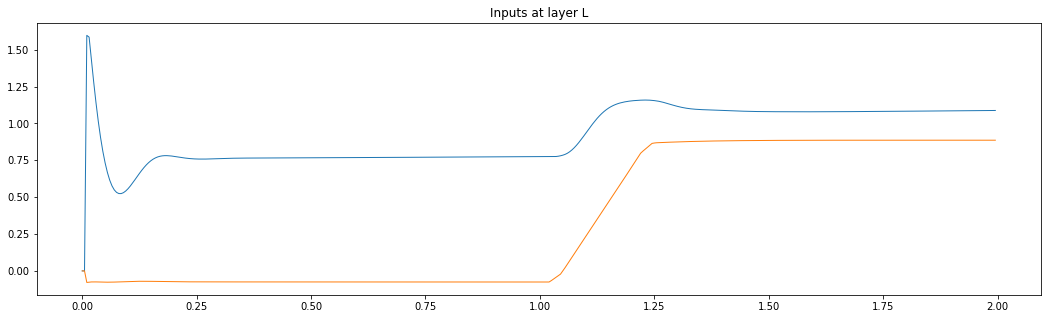

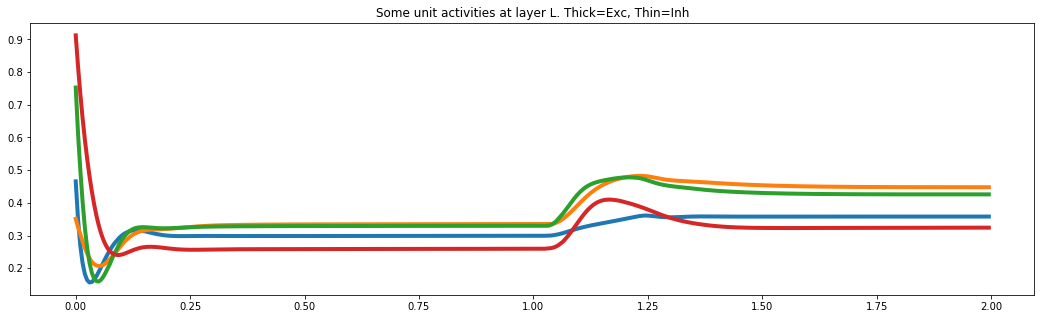

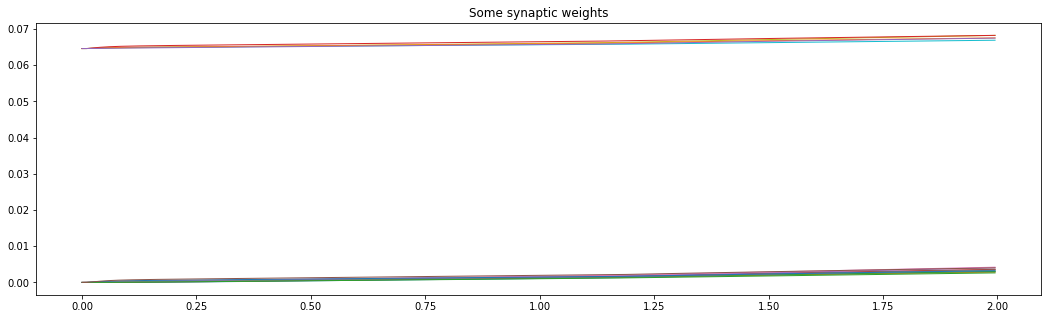

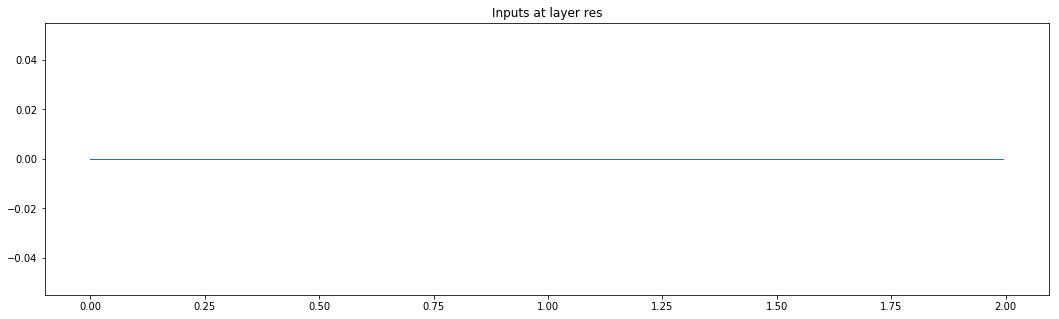

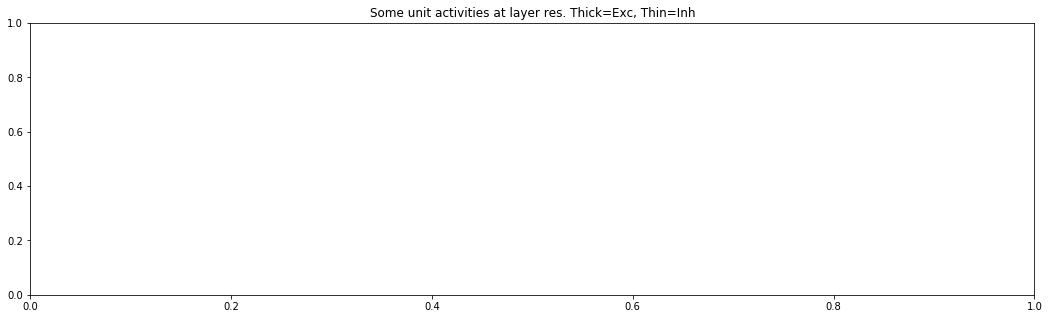

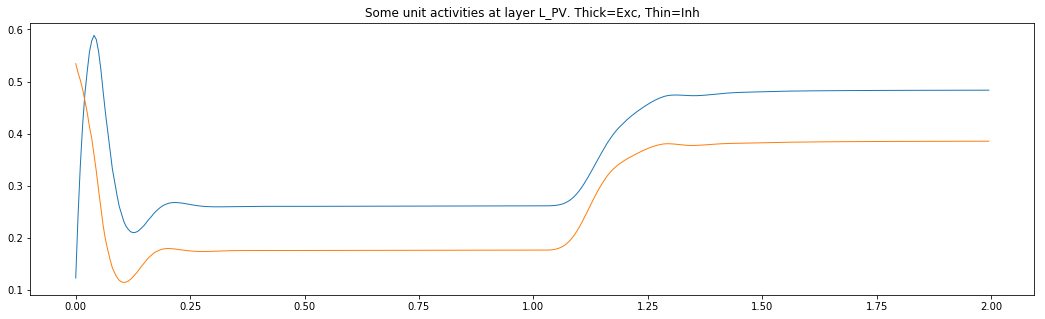

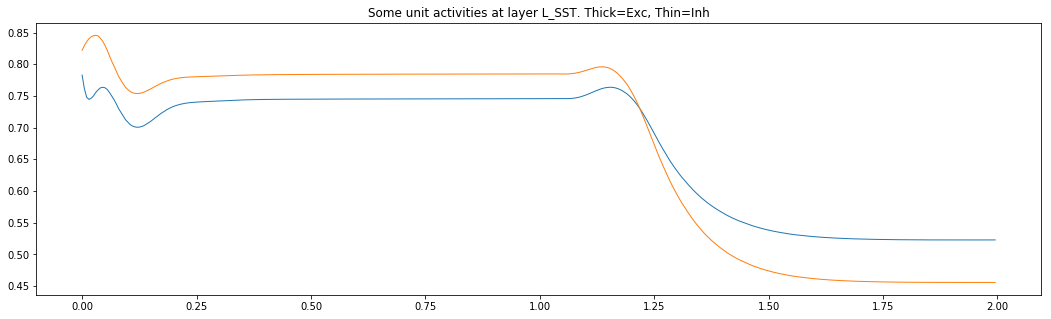

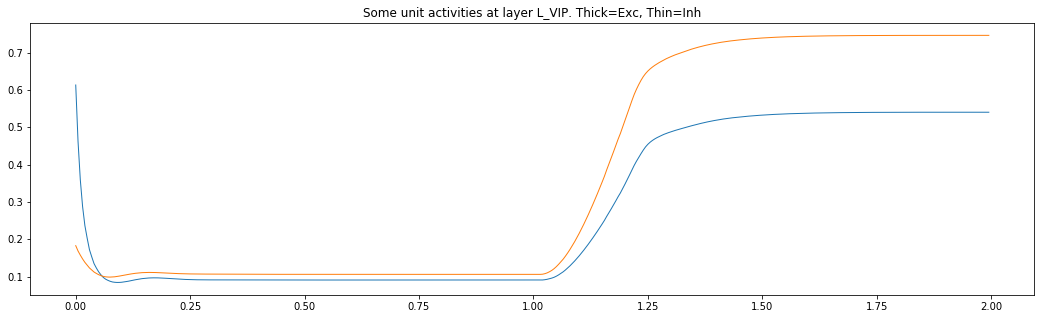

In [11]:
# basic plot 
%matplotlib inline
net_num = 0
net = proto_obj.nets[net_num]
L = net.layers['L']
D = net.layers['D']
res = net.layers['res']
L_SST = net.layers['L_SST']
L_PV = net.layers['L_PV']
L_VIP = net.layers['L_VIP']
#shrp = net.layers['shrp']
I1 = net.layers['inp1']
I2 = net.layers['inp2']
print(L.notes)
net.basic_plot('L')
#net.basic_plot('D')
net.basic_plot('res')
net.basic_plot('L_PV')
net.basic_plot('L_SST')
net.basic_plot('L_VIP')

norm of output matrix: 8.533807
norm of input matrix: 43.979793
norm of difference between matrices: 43.456938


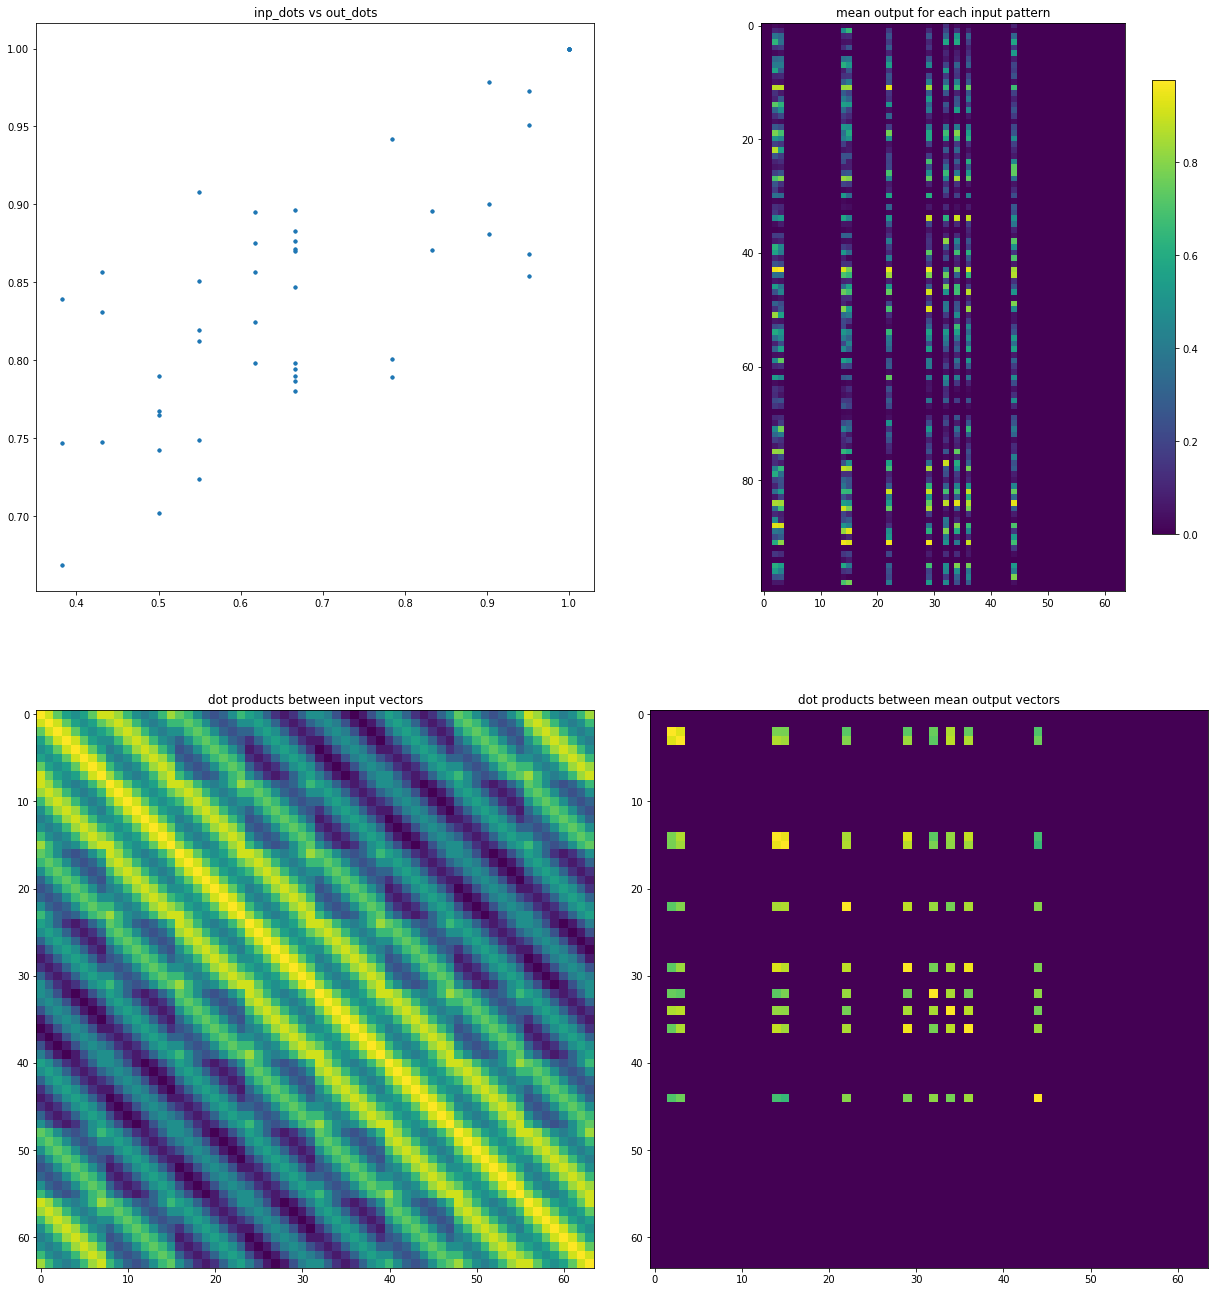

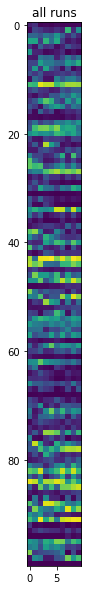

In [12]:
# input-output analysis
proto_obj.io_compare(net_num=net_num)

In [13]:
%matplotlib qt5
%matplotlib qt5
%matplotlib qt5
%matplotlib qt5
%matplotlib qt5
net.double_anim(L.e+I1.x+I2.x+L_SST.i+L_PV.i+L_VIP.i, slider=True, interv=10, nbins=20, thr=0.7, pdf=True)
#net.double_anim(L.e+I1.x+I2.x, slider=True, interv=10, nbins=20, thr=0.7, pdf=True)

interactive(children=(IntSlider(value=200, description='frame', max=400, min=1), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

norm of error in first part: 7.5946845717452325
std dev for desired value (first part): 7.230220786132965
norm of error in second part: 0.0
std dev for desired value (second part): 0.0


/home/z/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/z/.local/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


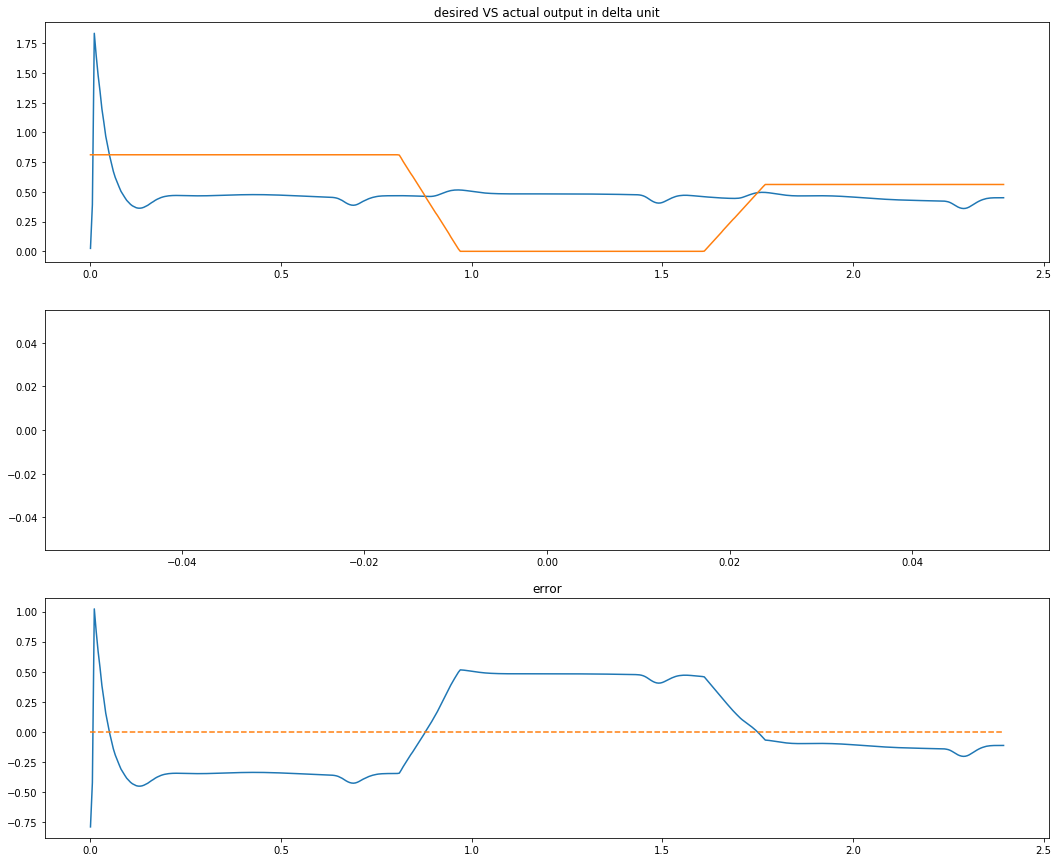

In [10]:
# compare output of the delta unit with the desired output
start_t = 0.
middle_t = 5.
end_t = 10.
proto_obj.des_D_compare(start_t, middle_t, end_t, net_num, make_history=False)

[27 51 81]


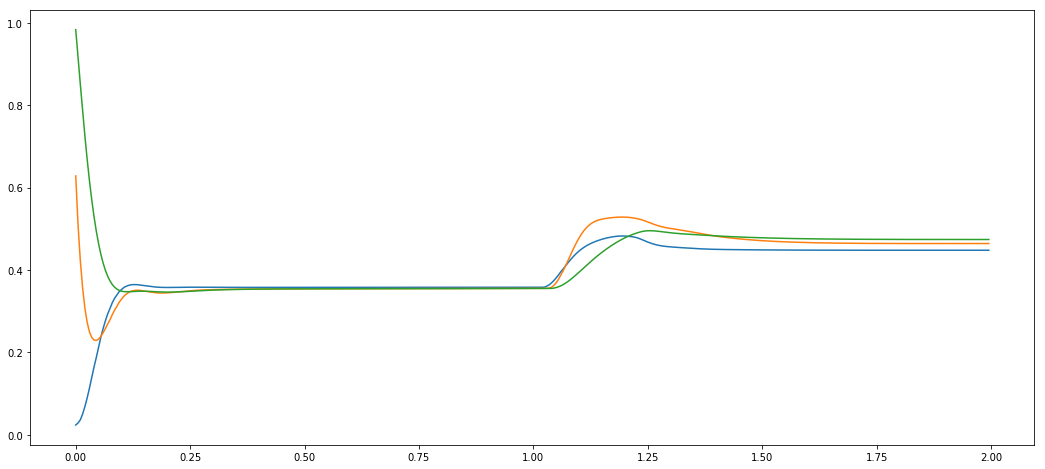

In [11]:
# Plot the highest excitatory unit activities
%matplotlib inline
n_top = 3  # how many units to plot
top_pop = np.array(L.e)  # population to visualize
top_units = net.all_activs[top_pop].sum(1).argpartition(-n_top)[-n_top:]
print(top_units)
top_act_fig = plt.figure(figsize=(18,8))
top_acts = net.all_activs[top_pop[top_units]].transpose()
plt.plot(net.all_times, top_acts)
plt.show()

[98 15 13]


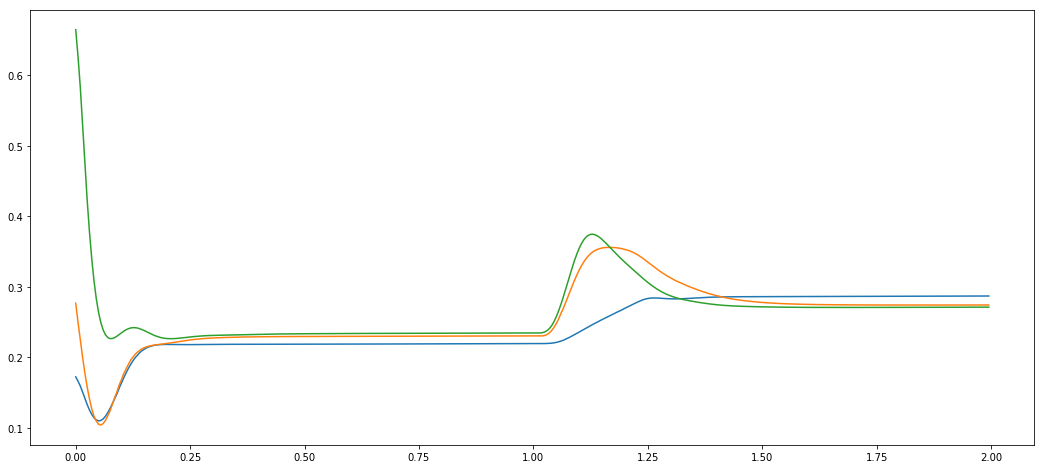

In [12]:
# Plot the lowest excitatory unit activities
n_bottom = 4  # how many units to plot
bottom_pop = np.array(L.e)  # population to visualize
bottom_units = net.all_activs[bottom_pop].sum(1).argpartition(n_bottom)[0:n_bottom-1]
print(bottom_units)
bottom_act_fig = plt.figure(figsize=(18,8))
bottom_acts = net.all_activs[bottom_pop[bottom_units]].transpose()
plt.plot(net.all_times, bottom_acts)
plt.show()

In [13]:
# Visualize the connections
%matplotlib qt5
%matplotlib qt5
%matplotlib qt5
%matplotlib qt5
%matplotlib qt5
#ei_net.conn_anim(I1.x+I2.x, L.e, slider=False)
#"""
net_num = 0
net = proto_obj.nets[net_num]
L = net.layers['L']
L_SST = net.layers['L_SST']
L_PV = net.layers['L_PV']
L_VIP = net.layers['L_VIP']
I1 = net.layers['inp1']
I2 = net.layers['inp2']
#"""
net.conn_anim(L.e+L_SST.i+L_PV.i+L_VIP.i, L.e+L_SST.i+L_PV.i+L_VIP.i, slider=True)
#net.conn_anim(I1.x+I2.x, L.e, slider=True)

interactive(children=(IntSlider(value=200, description='frame', max=400, min=1), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [8]:
# See the range of IDs for each layer
net_num = 0
einet = proto_obj.nets[net_num]

for lay_name in einet.layers:
    layer = einet.layers[lay_name]
    if hasattr(layer, 'e') and (len(layer.e) > 0):
        print(lay_name, end='.e = ')
        print(layer.e[0:5]+layer.e[-5:])
    if hasattr(layer, 'i') and (len(layer.i) > 0):
        print(lay_name, end='.i = ')
        print(layer.i[0:5]+layer.i[-5:])
    if hasattr(layer, 'x') and (len(layer.x) > 0):
        print(lay_name, end='.x = ')
        print(layer.x[0:5]+layer.x[-5:])

des.x = [0, 0]
D.e = [423, 423]
inp1.x = [1, 2, 3, 4, 5, 4, 5, 6, 7, 8]
L_VIP.i = [9, 10, 11, 12, 13, 104, 105, 106, 107, 108]
L.e = [209, 210, 211, 212, 213, 304, 305, 306, 307, 308]
upd.x = [314, 314]
L_PV.i = [315, 316, 317, 318, 319, 410, 411, 412, 413, 414]
inp2.x = [415, 416, 417, 418, 419, 418, 419, 420, 421, 422]
L_SST.i = [109, 110, 111, 112, 113, 204, 205, 206, 207, 208]
res.x = [426, 426]


In [19]:
# printing connections of a unit
einet = proto_obj.nets[0]
uid = einet.layers['L'].e[0]
own_lay = 'Le'
net = einet.net
    
for synlist in net.syns:
    for syn in synlist:
        if syn.preID == uid:
            post = syn.postID
            post_name = 'unidentified'
            for lay_name in einet.layers:
                lay = einet.layers[lay_name]
                if (hasattr(lay, 'e') and post in lay.e or
                    hasattr(lay, 'i') and post in lay.i or
                    hasattr(lay, 'x') and post in lay.x):
                    post_name = lay_name
                    break
            print(own_lay + ' --> ' +post_name + '(%d), w = %f, port = %d' % (post, syn.w, syn.port))
        elif syn.postID == uid:
            pre_name = 'unidentified'
            pre = syn.preID
            for lay_name in einet.layers:
                lay = einet.layers[lay_name]
                if (hasattr(lay, 'e') and pre in lay.e or
                    hasattr(lay, 'i') and pre in lay.i or
                    hasattr(lay, 'x') and pre in lay.x):
                    pre_name = lay_name
                    break
            print((pre_name + '(%d) --> ' % (syn.preID)) + own_lay + ', w = %f, port = %d' % (syn.w, syn.port))

Le --> L(17), w = 0.401840, port = 1
L(18) --> Le, w = 0.251769, port = 1
L(19) --> Le, w = 0.251832, port = 1
L(21) --> Le, w = 0.189892, port = 1
L(22) --> Le, w = 0.190096, port = 1
L(23) --> Le, w = 0.252149, port = 1
L(24) --> Le, w = 0.190213, port = 1
L(25) --> Le, w = 0.189961, port = 1
inp1(4) --> Le, w = 0.663813, port = 2
inp1(7) --> Le, w = 0.736076, port = 2
inp2(14) --> Le, w = 0.380656, port = 2
inp2(9) --> Le, w = 0.677077, port = 2
L_PV(37) --> Le, w = -2.000000, port = 0
L_SST(56) --> Le, w = -0.100000, port = 1
L_VIP(47) --> Le, w = -0.300000, port = 0
L_SST(56) --> Le, w = -0.100000, port = 2
Le --> L(18), w = 0.252005, port = 1
Le --> L(19), w = 0.251951, port = 1
Le --> L(20), w = 0.252261, port = 1
Le --> L(21), w = 0.190098, port = 1
Le --> L(22), w = 0.190226, port = 1
Le --> L(23), w = 0.252345, port = 1
Le --> L(25), w = 0.190082, port = 1
Le --> D(34), w = 0.046746, port = 0
Le --> L_PV(37), w = 0.280000, port = 0
Le --> L_PV(38), w = 0.208348, port = 0
Le -

In [14]:
# Annotations for individual networks
net.annotate("This is the original configuration of the cortical circuit, using the specifications in the  ")
net.annotate("connection notes of the 'microcolumn connections' tiddler, before setting they PYR<-->SST balance. ")
net.annotate("The basic responses of the different neuron types seem to be approaching what they are supposed")
net.annotate("to be, with a pattern of activation forming at the center of the criss-cross activation. ") 
net.annotate("However, this pattern can only be seen in the VIP response; PYRs have almost homogeneous activation")
net.annotate("all over the layer. The culprit seems to be the feedback inhibition from PV, and to a similar extent")
net.annotate("the inhibition from VIP, since the input causes a big reduction in SST activity.") 
net.annotate("The next step may be to reduce the PYR-->(VIP,PV) connection weights, and perhaps to increase the mutual")
net.annotate("inhibtion between VIP and SST.")
#net.annotate("")

In [15]:
# Write the configuration of the proto1 object in the simulation log
f = open(log_file, mode='a')
f.write(runner.stdout)
f.close()

In [16]:
# log all networks
proto_obj.log() 

In [ ]:
# saving
for net in proto_obj.nets:
    net.history.append('ei_net object being saved in container proto1 object ' + proto1_obj.name)
F = open(proto1_obj.name+'.pkl', 'wb')
dill.dump(proto1_obj, F)
F.close()

In [5]:
# loading
#F = open("/media/z/data/pickles/exp_dist_sig_test4.pkl", 'rb')
#F = open("/home/z/projects/draculab/sig_ssrdc_test1.pkl", 'rb')
F = open("/home/z/projects/draculab/sig_trdc_test1.pkl", 'rb')
mp_net_obj = dill.load(F)

In [3]:
mp_net_obj.code = str(runner)

NameError: name 'runner' is not defined

In [ ]:
# Continue running after loading
mp_net_obj.run_all(save=True, log=False, save_interv=10)

In [42]:
mp_net_obj.nets[4].history

['# ei_network.__init__ at Fri Jul 20 12:28:51 2018',
 'np.random.seed(19680801)',
 '# parallel runner assigned this network the number 4',
 "net_params = {   'atol': 1e-05,\n    'cm_del': 0.01,\n    'min_buff_size': 10,\n    'min_delay': 0.005,\n    'rtol': 1e-05}",
 "layer_names = ['L', 'I1', 'I2']",
 '# ()()()()() Non-default settings: ()()()()()',
 "I1x_Le_conn['connection_type'] = convergent",
 "I1x_Le_conn['number_of_connections'] = 2",
 "I1x_Le_conn['mask'] = {'circular': {'radius': 5.0}}",
 "I1x_Le_conn['kernel'] = {'linear': {'a': 0.5, 'c': 1.0}}",
 "I1x_Le_conn['weights'] = {'uniform': {'high': 0.9, 'low': 0.2}}",
 "I1x_Le_conn['dist_dim'] = y",
 "I1x_Le_conn['edge_wrap'] = False",
 "I1x_Le_syn['inp_ports'] = 1",
 "I1x_Le_syn['type'] = synapse_types.bcm",
 "I1x_Le_syn['lrate'] = 0.01",
 "I1x_Li_conn['connection_type'] = convergent",
 "I1x_Li_conn['number_of_connections'] = 2",
 "I1x_Li_conn['mask'] = {'circular': {'radius': 5.0}}",
 "I1x_Li_conn['kernel'] = {'linear': {'a': 0

In [ ]:
# mean activity given the rate distribution
c = 3
a = np.exp(-c)
b = 1-a
mean = (b/c**3)*(1. - (c+1.)*a)
print(mean)

n_points = 1000
r = np.linspace(0.,1.,n_points)
pdf = (b/c)*np.exp(-c*r)
mean2 = np.dot(r,pdf)/n_points
print(mean2)

In [ ]:
for n in range(11):
    mp_net_obj.nets[n+1].log(log_file, False)

In [ ]:
# visualizing sigmoidals
g = 4.
th = .6
f = lambda x: 1./(1. + np.exp(-g*(x-th)))
fp = lambda x: g * (1. - f(x)) * f(x)
dom = np.linspace(-4., 4., 200)

%matplotlib inline
plt.figure(figsize=(16,5))
plt.plot(dom, [f(x) for x in dom])
plt.grid(axis='both')
plt.figure(figsize=(16,5))
plt.plot(dom, [fp(x) for x in dom], 'r')
plt.grid(axis='both')
plt.show()

In [8]:
np.tan(np.pi/6)**2

0.3333333333333333